In [1]:
import pandas as pd

In [2]:
import plotly.express as px 

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [47]:
import requests

In [4]:
pip install matplotlib seaborn

/Users/arijuljulian/.zshenv:source:1: no such file or directory: /Users/arijuljulian/.cargo/env
Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [7]:
from understatapi import UnderstatClient

In [8]:
understat = UnderstatClient()

In [9]:
# Premier League player data for 2018 season
pl_player_2018 = understat.league(league="EPL").get_player_data(season="2018")
pl_18 = pd.DataFrame(pl_player_2018)

In [10]:
# Premier League player data for 2022 season
pl_player_2022 = understat.league(league="EPL").get_player_data(season="2022")
pl_22 = pd.DataFrame(pl_player_2022)

In [35]:
# Premier League player data for 2023 season
pl_player_2023 = understat.league(league="EPL").get_player_data(season="2023")

In [36]:
# Helper function: gets season data for team inputted during select season
def get_team_data(team_name, year):

    with UnderstatClient() as understat:
        team_match_data = understat.team(team=team_name).get_match_data(season=year)
    
    return pd.DataFrame(team_match_data)

In [37]:
# Get data for every player playing in the Premier League in 2019/20
league_player_data = understat.league(league="EPL").get_player_data(season="2019")

# Get the name and id of one of the players
player_id, player_name = league_player_data[0]["id"], league_player_data[0]["player_name"]

# Get data for every shot this player has taken in a league match (for all seasons)
player_shot_data = understat.player(player=player_id).get_shot_data()

In [38]:
# Get data for every league match involving Manchester United in 2019/20
team_match_data = understat.team(team="Manchester_United").get_match_data(season="2019")

# Get the id for the first match of the season
match_id = team_match_data[0]["id"]

# Get the rosters for the both teams in that match
roster_data = understat.match(match=match_id).get_roster_data()

In [39]:
pl_player_df = pd.DataFrame(pl_player_2023)

# Data Cleaning

In [40]:
# Converting specific columns to numeric
cols_to_convert = ['xG', 'xA', 'npxG', 'xGChain', 'xGBuildup']

for col in cols_to_convert:
    pl_player_df[col] = pd.to_numeric(pl_player_df[col], errors='coerce')

In [41]:
# Rounding below columns to two decimal columns
cols_to_round = ['xG', 'xA', 'npxG', 'xGChain', 'xGBuildup']

for col in cols_to_round:
    pl_player_df[col] = pl_player_df[col].round(2)

# Shot Data Visualizations

In [18]:
saka_id = pl_player_df[pl_player_df['player_name'] == 'Bukayo Saka'].iloc[0]['id']
saka_id

'7322'

In [19]:
pl_player_df

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,6049,Solly March,3,241,3,2.15,0,0.15,10,5,0,0,M,Brighton,3,2.15,2.92,0.85
1,6552,Bryan Mbeumo,3,270,3,3.05,0,0.26,7,3,0,0,F,Brentford,1,1.53,1.60,0.07
2,7814,Taiwo Awoniyi,3,183,3,1.67,0,0.08,5,2,0,0,F S,Nottingham Forest,3,1.67,1.72,0.02
3,8260,Erling Haaland,3,265,3,3.39,0,0.41,16,4,0,0,F,Manchester City,3,2.63,2.98,0.50
4,531,Michail Antonio,3,247,2,0.91,0,0.16,5,1,1,0,F,West Ham,2,0.91,1.68,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,11807,Ian Maatsen,2,4,0,0.00,0,0.00,0,0,1,0,S,Chelsea,0,0.00,0.00,0.00
363,11810,Mason Burstow,2,2,0,0.00,0,0.00,0,0,0,0,S,Chelsea,0,0.00,0.00,0.00
364,11926,Edson Álvarez,2,89,0,0.00,0,0.00,0,0,1,0,M S,West Ham,0,0.00,0.00,0.00
365,11984,Youssef Chermiti,1,22,0,0.07,0,0.00,1,0,1,0,S,Everton,0,0.07,0.00,0.00


In [20]:
# Draws football pitch

def draw_pitch():
    # Setup the field
    fig, ax = plt.subplots(figsize=(10,7))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Draw the field boundary
    plt.plot([0, 0, 1, 1, 0], [0, 1, 1, 0, 0], color="green")
    
    # Goal boxes (can add more details like penalty spots, half-line, etc.)
    plt.plot([0, 0.2, 0.2, 0], [0.22, 0.22, 0.78, 0.78], color="green")
    plt.plot([1, 0.8, 0.8, 1], [0.22, 0.22, 0.78, 0.78], color="green")
    
    return fig, ax

In [26]:
# Function to draw shot map from the given DataFrame

def draw_shot_map(df):
    fig, ax = draw_pitch()

    # Adjusting the coordinates
    df['X'] = 1 - df['X'].astype(float)
    df['Y'] = 1 - df['Y'].astype(float)
    
    shot_palette = {'Goal': 'green', 'MissedShots': 'red', 'SavedShot': 'red',
                    'BlockedShot': 'red', 'ShotOnPost': 'blue', 'OwnGoal': 'purple'}
    
    sns.scatterplot(data=df, x='X', y='Y', hue='result', size='xG', sizes=(5, 100), palette=shot_palette, ax=ax)
    plt.title("Shot Map")

    # Adjusting the legend
    leg = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})
    for lh in leg.legendHandles:
        lh.set_alpha(1)  # Ensure the legend markers are not transparent
    
    plt.show()

In [27]:
# Function to fetch data and draw the shot map for a given player ID

def plot_player_shots(player_id):
    with UnderstatClient() as understat:
        shots_data = understat.player(player=player_id).get_shot_data()

     
    df = pd.DataFrame(shots_data)
    df['xG'] = pd.to_numeric(df['xG'], errors='coerce')
    df['xG'] = df['xG'].round(2)
    df = df[['X', 'Y', 'result', 'xG']]
    draw_shot_map(df)

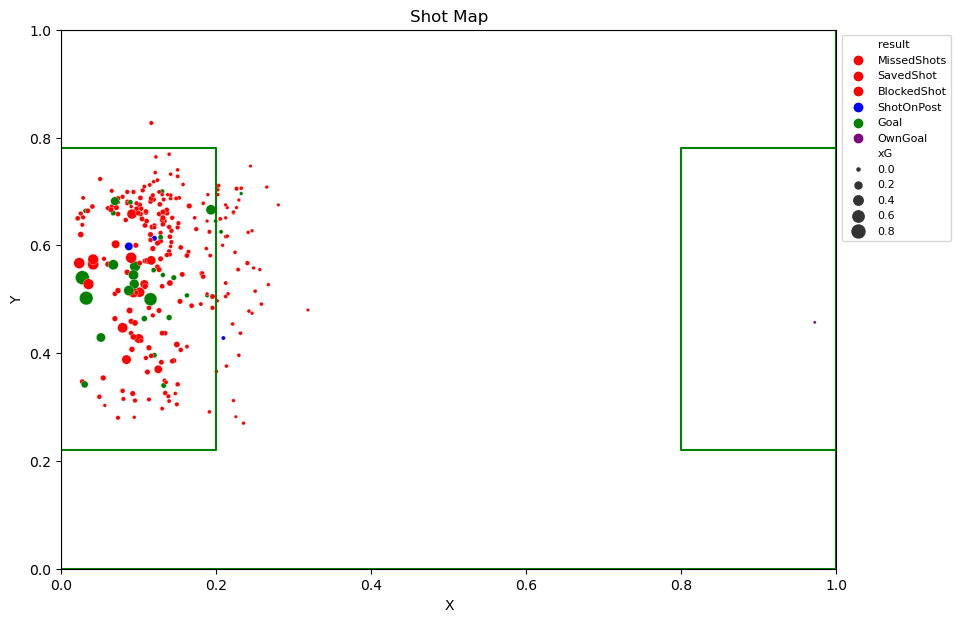

In [28]:
# Example usage with Bukayo Saka

plot_player_shots(saka_id)

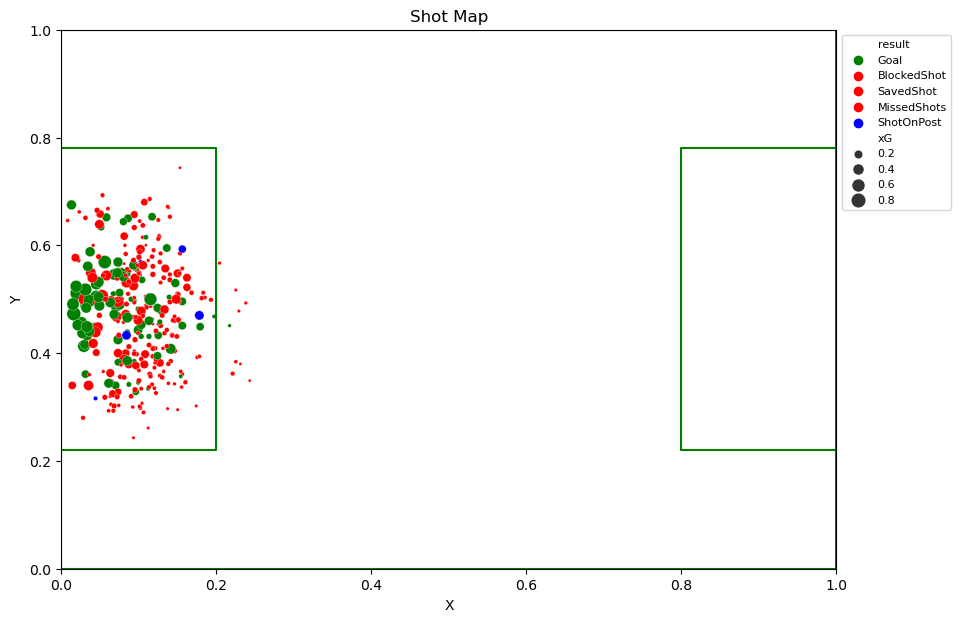

In [29]:
# Example usage with Erling Haaland (tap-in merchant)

haaland_id = pl_player_df[pl_player_df['player_name'] == 'Erling Haaland'].iloc[0]['id']
plot_player_shots(haaland_id)

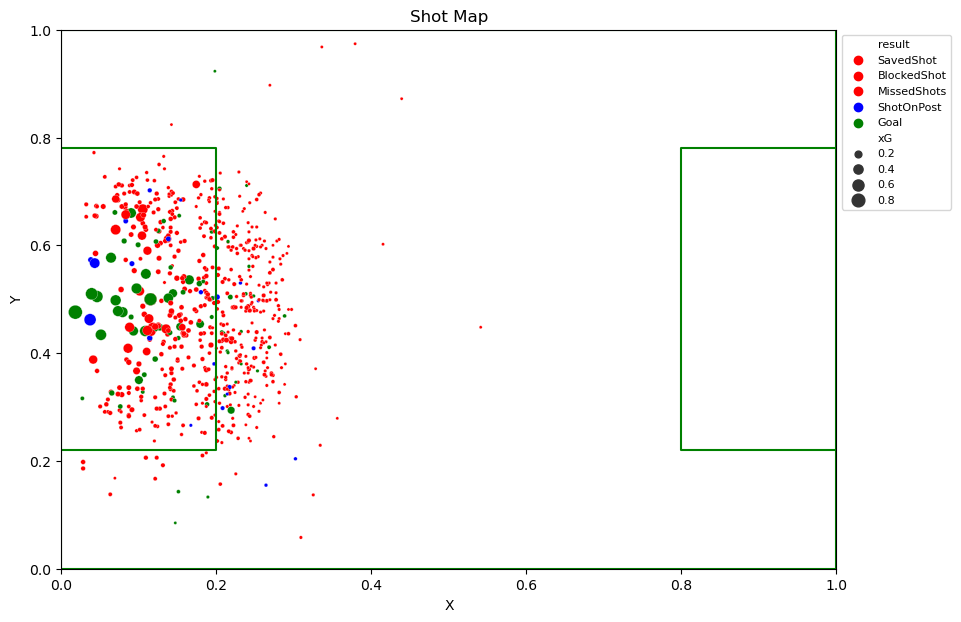

In [30]:
# Example usage with Kevin De Bruyne

kdb_id = pl_player_df[pl_player_df['player_name'] == 'Kevin De Bruyne'].iloc[0]['id']
plot_player_shots(kdb_id)

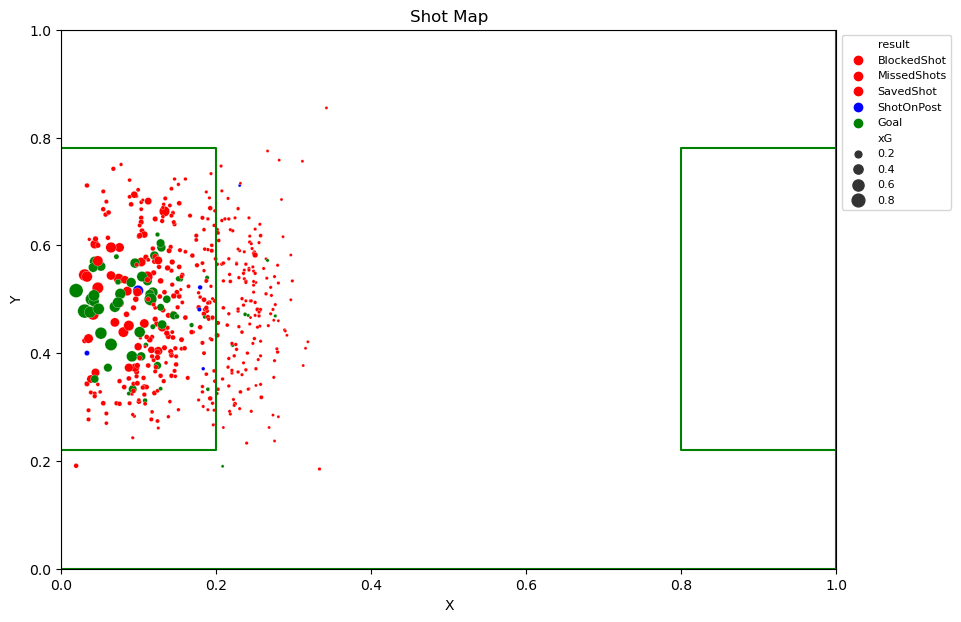

In [31]:
# Example usage with Henrikh Mkhitaryan

micki_id = pl_18[pl_18['player_name'] == 'Henrikh Mkhitaryan'].iloc[0]['id']
plot_player_shots(micki_id)

# Is xG linear throughout a game?

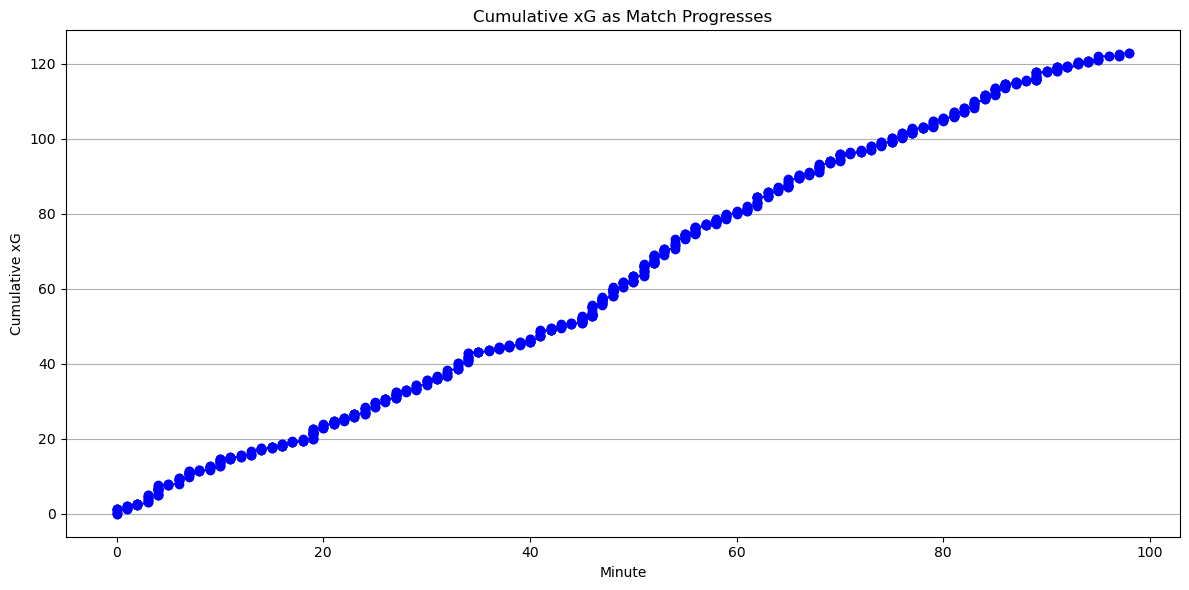

In [32]:
with UnderstatClient() as understat:
    
    # Fetch Arsenal's match data for 2022
    matches = pd.DataFrame(understat.team(team="Arsenal").get_match_data(season="2022"))

    # Fetch every match_id from the season
    match_ids = matches['id'].tolist()

    # Get list of all shots from season
    all_shots = []
    for match_id in match_ids:
        shots = understat.match(match=match_id).get_shot_data()
        shots = shots['h'] + shots['a']
        all_shots.extend(shots)

    df = pd.DataFrame(all_shots)
    df = df[['minute', 'xG', 'result']]
    df['xG'] = pd.to_numeric(df['xG'])
    df['minute'] = pd.to_numeric(df['minute'])
    df['xG'] = df['xG'].round(2)

    # Sort by minute and calculate cumulative sum
    df = df.sort_values(by='minute')
    df['cumulative_xG'] = df['xG'].cumsum()

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df['minute'], df['cumulative_xG'], marker='o', color='blue', drawstyle='steps-post')
    plt.title('Cumulative xG as Match Progresses')
    plt.xlabel('Minute')
    plt.ylabel('Cumulative xG')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # # Define the bins and labels
    # bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    # labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']
    # df['binned'] = pd.cut(df['minute'], bins=bins, labels=labels, right=False)

    # # Group by the binned column and sum the xG values
    # sum_xG = df.groupby('binned')['xG'].sum().reset_index()

    # # Plotting
    # plt.figure(figsize=(12, 6))
    # plt.bar(sum_xG['binned'], sum_xG['xG'], color='blue')
    # plt.title('Total xG by Minute Intervals for the Season')
    # plt.xlabel('Minute Interval')
    # plt.ylabel('Total xG')
    # plt.grid(axis='y')
    # plt.show()

# K-means Clustering (Which players are most similar?)

In [61]:
# Load the DataFrame

df = pl_player_df
df

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup,Cluster
0,8260,Erling Haaland,4,355,6,4.72,1,1.10,20,6,0,0,F,Manchester City,5,3.20,4.24,0.50,0
1,6552,Bryan Mbeumo,4,360,4,3.80,0,0.47,9,5,0,0,F,Brentford,2,2.28,3.40,1.01,0
2,10177,Evan Ferguson,4,205,4,2.23,0,0.07,13,1,0,0,F S,Brighton,4,2.23,2.67,0.37,0
3,453,Son Heung-Min,4,343,3,1.45,0,1.32,10,9,0,0,F M,Tottenham,3,1.45,4.07,1.54,0
4,1776,Jarrod Bowen,4,360,3,1.85,1,0.81,13,4,1,0,M,West Ham,3,1.85,2.13,0.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,11903,Oscar Bobb,1,1,0,0.00,0,0.00,0,0,0,0,S,Manchester City,0,0.00,0.13,0.13,1
388,11926,Edson Álvarez,3,179,0,0.06,0,0.05,1,1,1,0,M S,West Ham,0,0.06,0.66,0.55,1
389,11984,Youssef Chermiti,1,22,0,0.07,0,0.00,1,0,1,0,S,Everton,0,0.07,0.00,0.00,1
390,11998,Hannes Delcroix,2,129,0,0.23,0,0.08,4,2,1,0,D S,Burnley,0,0.23,0.58,0.49,1


In [62]:
# Data Preprocessing

features = ['goals', 'assists', 'xG', 'xA', 'shots', 'key_passes', 'npxG', 'xGChain', 'xGBuildup']
df_filtered = df[features]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtered)

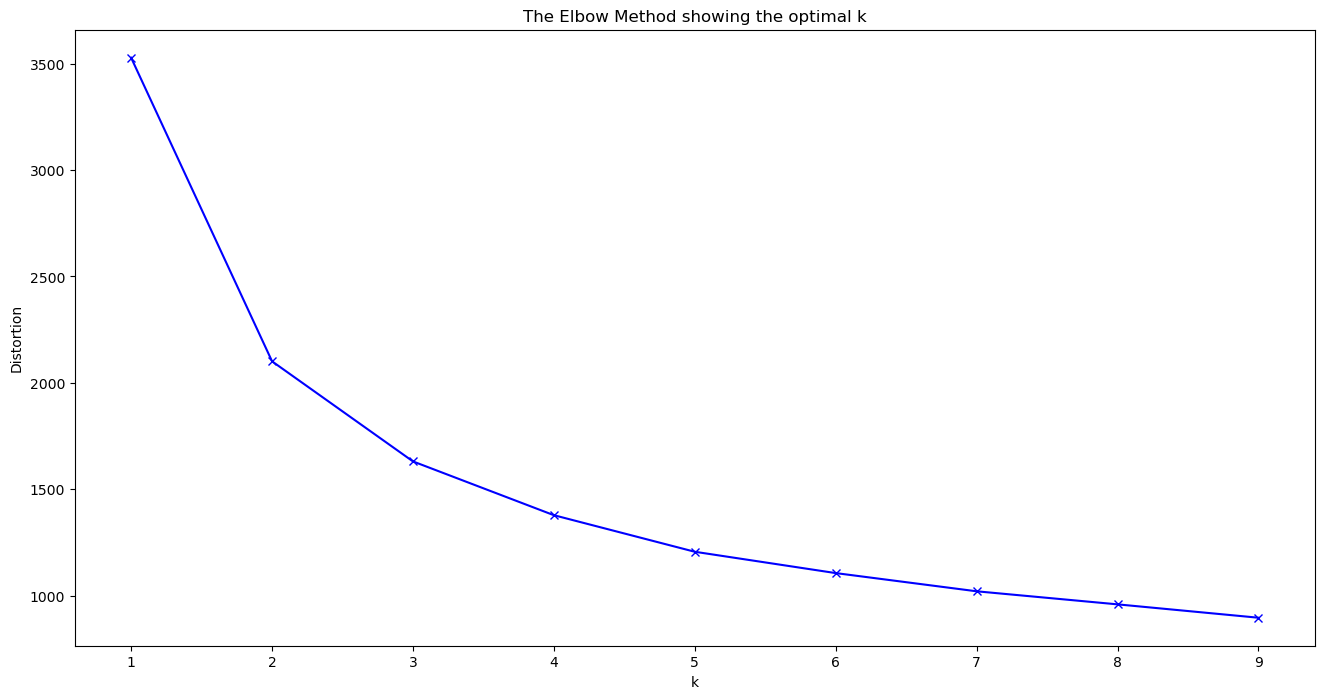

In [63]:
# Determing optimal number of clusters

distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [64]:
# Fitting the Model

optimal_k = 4
kmeanModel = KMeans(n_clusters=optimal_k)
kmeanModel.fit(df_scaled)

KMeans(n_clusters=4)

In [65]:
df['Cluster'] = kmeanModel.labels_

# Which teams overperform/underperform their xG?

In [72]:
matches = pd.DataFrame(understat.team(team="Arsenal").get_match_data(season="2023"))
matches

,id,isResult,side,h,a,goals,xG,datetime,forecast,result
0,22276,True,h,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '249', 'title': 'Nottingham Forest', 's...","{'h': '2', 'a': '1'}","{'h': '0.84262', 'a': '0.966305'}",2023-08-12 11:30:00,"{'w': 0.30280789728352503, 'd': 0.326964500411...",w
1,22294,True,a,"{'id': '78', 'title': 'Crystal Palace', 'short...","{'id': '83', 'title': 'Arsenal', 'short_title'...","{'h': '0', 'a': '1'}","{'h': '1.06916', 'a': '2.20593'}",2023-08-21 19:00:00,"{'w': 0.1729654304374391, 'd': 0.1955964256039...",w
2,22297,True,h,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '228', 'title': 'Fulham', 'short_title'...","{'h': '2', 'a': '2'}","{'h': '3.23088', 'a': '0.849817'}",2023-08-26 14:00:00,"{'w': 0.8298027263809358, 'd': 0.1067072057001...",d
3,21934,True,h,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '89', 'title': 'Manchester United', 'sh...","{'h': '3', 'a': '1'}","{'h': '1.90973', 'a': '0.966109'}",2023-09-03 15:30:00,"{'w': 0.5944017219232832, 'd': 0.2193964758720...",w
4,21941,False,a,"{'id': '72', 'title': 'Everton', 'short_title'...","{'id': '83', 'title': 'Arsenal', 'short_title'...","{'h': None, 'a': None}","{'h': None, 'a': None}",2023-09-16 16:30:00,NaN,NaN
5,21952,False,h,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '82', 'title': 'Tottenham', 'short_titl...","{'h': None, 'a': None}","{'h': None, 'a': None}",2023-09-24 13:00:00,NaN,NaN
6,21959,False,a,"{'id': '73', 'title': 'Bournemouth', 'short_ti...","{'id': '83', 'title': 'Arsenal', 'short_title'...","{'h': None, 'a': None}","{'h': None, 'a': None}",2023-09-30 14:00:00,NaN,NaN
7,21965,False,h,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '88', 'title': 'Manchester City', 'shor...","{'h': None, 'a': None}","{'h': None, 'a': None}",2023-10-07 14:00:00,NaN,NaN
8,21978,False,a,"{'id': '80', 'title': 'Chelsea', 'short_title'...","{'id': '83', 'title': 'Arsenal', 'short_title'...","{'h': None, 'a': None}","{'h': None, 'a': None}",2023-10-21 14:00:00,NaN,NaN
9,21986,False,h,"{'id': '83', 'title': 'Arsenal', 'short_title'...","{'id': '238', 'title': 'Sheffield United', 'sh...","{'h': None, 'a': None}","{'h': None, 'a': None}",2023-10-28 14:00:00,NaN,NaN
